In [1]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

# Compare models

In [22]:
from scipy.stats import bootstrap
trainmodel = "HYDRO_FIDUCIAL"
testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive"]
names = [r"+2$\sigma$ fgas", "Fiducial", r"-2$\sigma fgas$", r"-4$\sigma fgas$", r"-8$\sigma fgas$", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]

p["model"] = trainmodel
data = Data(p)
filename = p_to_filename(p)
nnmodel = torch.load(f"{p['model_path']}/{filename}_dm.pt", map_location=torch.device("cpu"))

def rmse(d):
    return np.sqrt(np.mean((d)**2))

In [3]:
def predict_with_scaling_relations(testmodels):
    pred_low = []
    pred_high = []
    ### load scaling relation for trainmodel
    p["model"] = trainmodel
    spl_low = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_low.npy", allow_pickle=True)[()]
    spl_high = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_high.npy", allow_pickle=True)[()]

    for testmodel in testmodels:
        ### From testset(trainingset also possible) images take luminosity within r_500crit and use it to predict mass using trainmodel scaling relation
        p["model"] = testmodel
        data = Data(p)
        data.load_testset(filename=p_to_filename(p))
        pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
        points_low = []
        points_high = []
        for i, haloindex in enumerate(data.indices):
            r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
            radius = r / pixel_size
            X, Y = np.ogrid[:p['resolution'], :p['resolution']]
            dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
            mask_circ = dist_from_center<=radius
            luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
            luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))
            points_low.append(10**spl_low(luminosity_circle_low))
            points_high.append(10**spl_high(luminosity_circle_high))
        pred_low.append(points_low)
        pred_high.append(points_high)
        print(f"{testmodel} done")
    return pred_low, pred_high
    

In [4]:
def predict_with_nn(testmodels):
    predictions = []
    p["model"] = trainmodel
    data = Data(p)
    filename = p_to_filename(p)
    data.make_nn_dataset(filename=filename)
    std_y = data.std_y
    mean_y = data.mean_y
    for testmodel in testmodels:
        p["model"] = testmodel
        data = Data(p)
        filename = p_to_filename(p)
        data.make_nn_dataset(filename=filename)
        data.load_testset(filename=filename)
        with torch.no_grad():
            prediction = 10**(nnmodel(torch.Tensor(data.testx)).squeeze(1) * std_y + mean_y)
        predictions.append(prediction)
        print(f"{testmodel} done")
    return predictions

In [19]:
predictions = predict_with_nn(testmodels)
# pred_low, pred_high = predict_with_scaling_relations(testmodels)

HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


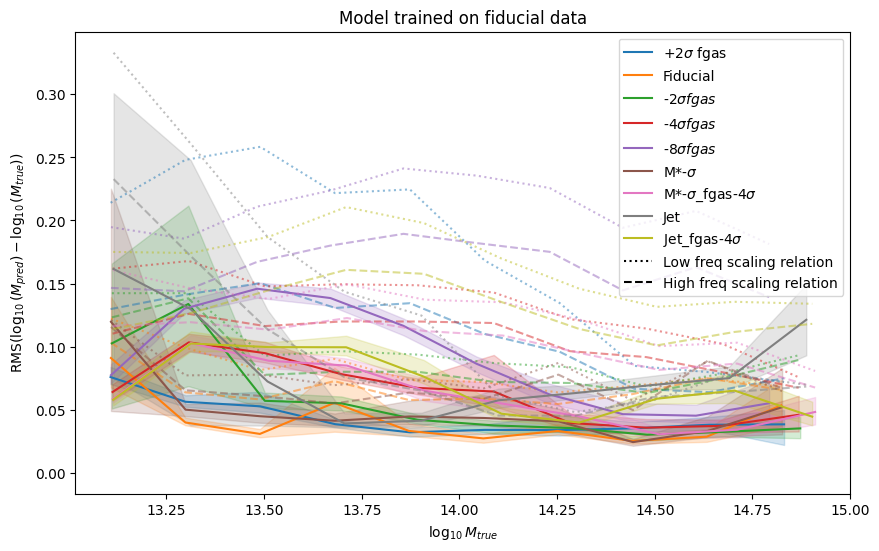

In [28]:
plt.figure(figsize=(10, 6))
for i, testmodel in enumerate(testmodels):
    p["model"] = testmodel
    masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
    testmasses = masses[:int(len(masses)*p["test_size"])]
    nr_bins = 10
    bin_edges = np.logspace(np.log10(np.min(testmasses)), np.log10(np.max(testmasses)), nr_bins+1)

    ### low
    x = np.array([])
    y = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        error = np.log10(np.array(pred_low[i])[indices]) - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(rmse(error)))
    plt.plot(x, y, color=colors[i], ls="dotted", alpha=0.5)
    ### high
    x = np.array([])
    y = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        error = np.log10(np.array(pred_high[i])[indices]) - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(rmse(error)))
    plt.plot(x, y, color=colors[i], ls="dashed", alpha=0.5)
    ### network
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        error = np.log10(np.array(predictions[i])[indices]) - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(rmse(error)))
        b = bootstrap((error,), rmse, confidence_level=0.84, n_resamples=100)
        perc16 = np.append(perc16, b.confidence_interval.low)
        perc84 = np.append(perc84, b.confidence_interval.high)
    plt.plot(x, y, color=colors[i], label=names[i])
    plt.fill_between(x, perc16, perc84, color=colors[i], alpha=0.2)




plt.ylabel("RMS($\log_{10}(M_{pred}) - \log_{10}(M_{true})$)")
plt.xlabel("$\log_{10} M_{true}$")
# plt.xlim(13, 15)
# plt.ylim(-0.6, 0.6)
plt.title("Model trained on fiducial data")
# plt.plot([14], [0], color="black", label="")
plt.plot([14], [0], color="black", label="Low freq scaling relation", ls="dotted")
plt.plot([14], [0], color="black", label="High freq scaling relation", ls="dashed")
plt.legend()#loc=(0.9, 0))

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
plt.savefig("compare_"+trainmodel+"_rmse", dpi=300)
plt.show()

In [7]:
print(len(data.masses))
print(len(pred_low[0]))

AttributeError: 'Data' object has no attribute 'masses'

In [6]:
for testmodel in testmodels:
    p["model"] = testmodel
    data = Data(p)
    filename = p_to_filename(p)
    data.make_nn_dataset(filename=filename)
    print(data.std_y, data.mean_y, data.std_x, data.mean_x)

0.47545975 13.804459 [1.36880582 1.93725696] [38.17632171 36.63077633]
0.47429058 13.801131 [1.28347023 1.83466008] [38.24230068 36.77187307]
0.47268867 13.797925 [1.23953935 1.77352183] [38.26199149 36.84918389]
0.47114006 13.796522 [1.2122791  1.73096587] [38.2713122  36.91066283]
0.46806544 13.788439 [1.1932881  1.67970094] [38.23529517 36.94451818]


In [4]:
# def get_gasfrac(testmodel):
#     p["model"] = testmodel
#     data = Data(p)
#     gasmass = data.soap_file["SO/500_crit/GasMass"][()]
#     totalmass = data.soap_file["SO/500_crit/TotalMass"][()]
#     indices = (gasmass > 0)*(totalmass>0)*(totalmass>1e13)*(totalmass<1e15)
#     gasmass = gasmass[indices]
#     totalmass = totalmass[indices]
#     massfractions = gasmass / totalmass
#     bins = np.logspace(13, 15, 20)
#     gasfrac = []
#     mass = []
#     for i in range(len(bins)-1):
#         indices = np.logical_and(totalmass > bins[i], totalmass < bins[i+1])
#         gasfrac.append(np.median(massfractions[indices]))
#         mass.append(np.mean(totalmass[indices]))
#     return gasfrac, mass

# def plot_expected(testmodels):
#     gasfrac_train, mass = get_gasfrac(trainmodel)
#     for testmodel in testmodels:
#         gasfrac_test, _ = get_gasfrac(testmodel)
#         plt.plot(np.log10(mass), 1.6*np.log10(np.array(gasfrac_test)/np.array(gasfrac_train)), color=colors[testmodels.index(testmodel)])


# plot_expected(["HYDRO_WEAK_AGN"])#, "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN"])
# plt.show()

In [49]:
p["model"] = testmodel
data = Data(p)
filename = p_to_filename(p)
data.make_nn_dataset(filename=filename)
data.load_testset(filename=filename)

In [50]:
with torch.no_grad():
    prediction = 10**(nnmodel(torch.Tensor(data.testx)).squeeze(1) * data.std_y + data.mean_y)

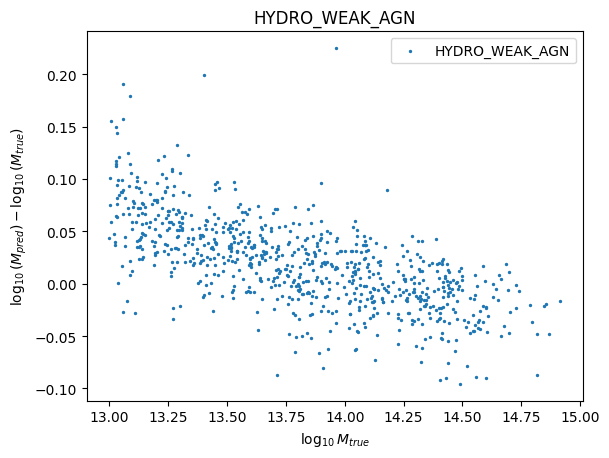

[1.00158671e+13 1.55684641e+13 2.41993102e+13 3.76149252e+13
 5.84678898e+13 9.08813220e+13 1.41264115e+14 2.19578124e+14
 3.41307857e+14 5.30522128e+14 8.24633017e+14]
tensor([ 0.0814,  0.0993,  0.0360,  0.0977,  0.0011,  0.0665,  0.0542,  0.0395,
         0.0443,  0.0724,  0.0912,  0.0774,  0.0370,  0.0352,  0.0848,  0.0969,
         0.0476,  0.0757,  0.1206,  0.0764,  0.0786,  0.0481,  0.0895, -0.0279,
         0.0724,  0.0800,  0.0636,  0.0468,  0.1497,  0.0417,  0.1248,  0.0336,
         0.0470,  0.0941,  0.1122,  0.0357,  0.0169, -0.0272,  0.0182,  0.0879,
         0.1142,  0.0675,  0.0928,  0.0593,  0.0399,  0.0256,  0.0994,  0.1555,
         0.1789,  0.0723,  0.1010,  0.0518,  0.0757,  0.0082,  0.0728,  0.0592,
         0.1171,  0.0586,  0.0237,  0.0769,  0.0880,  0.0236,  0.0594,  0.1018,
         0.1437,  0.0431,  0.1145,  0.0212,  0.0873,  0.0921,  0.0410,  0.0448,
         0.1054,  0.0404,  0.1574,  0.0734,  0.0858,  0.0647,  0.0583,  0.0657,
         0.0358,  0.0348,  0.19

In [57]:
plt.scatter(np.log10(data.masses), np.log10(prediction) - np.log10(data.masses), label=testmodel, s=2)
plt.ylabel("$\log_{10}(M_{pred}) - \log_{10}(M_{true})$")
plt.xlabel("$\log_{10} M_{true}$")
plt.title(p["model"])
plt.legend()
plt.show()


# nr_bins = 10
# x = np.array([])
# y = np.array([])
# perc16 = np.array([])
# perc84 = np.array([])
# bin_edges = np.logspace(np.log10(np.min(data.masses)), np.log10(np.max(data.masses)), nr_bins+1)
# for b in range(nr_bins):
#     indices = np.logical_and(data.masses > bin_edges[b], data.masses < bin_edges[b+1])
#     error = np.log10(prediction[indices]) - np.log10(data.masses[indices])
#     x = np.append(x, np.mean([bin_edges[b], bin_edges[b+1]]))
#     y = np.append(y, np.sqrt(np.mean((error)**2)))
#     perc16 = np.append(perc16, np.percentile(abs(error), 16))
#     perc84 = np.append(perc84, np.percentile(abs(error), 84))
# plt.plot(x, y, label=testmodel)
# plt.fill_between(x, perc16, perc84, alpha=0.1)
#     # plt.plot(x, perc16, ls="dashed", color=colors[i])
# # plt.hlines(0.0, np.min(data.masses), np.max(data.masses), colors="black", linestyles="dashed", alpha=0.8)
# # plt.plot((np.min(x), 0),(np.max(x), 0), color='black', ls='dashed', label="16th percentile")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("M$_{500c}$ $(M_\odot)$")
# plt.ylabel("Root Mean Squared Error")
# # plt.title(p["model"])
# plt.legend()
# plt.show()

# difference plots 14 nov


In [2]:
# p["soapfile"] = "halo_properties_0078.hdf5"
# p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
# p["snapshot_folder"] = "snapshots_reduced"
# p["simsize"] = "L2800N5040"
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
filename = p_to_filename(p)
data.make_nn_dataset(filename=filename)
data.load_testset(filename=filename)


predictions = np.ndarray((len(data.images), 5))

In [3]:
print(data.std_x, data.std_y)

[1.27418703 1.0151683 ] 0.46188265


In [7]:
### predict with NN
nnmodel = torch.load(f"{p['model_path']}/{p_to_filename(p)}.pt", map_location=torch.device("cpu"))
# nnmodel2 = torch.load(f"{p['model_path']}/{p_to_filename(p)}_big.pt", map_location=torch.device("cpu"))
nnmodel_low = torch.load(f"{p['model_path']}/{p_to_filename(p)}low.pt", map_location=torch.device("cpu"))
nnmodel_high = torch.load(f"{p['model_path']}/{p_to_filename(p)}high.pt", map_location=torch.device("cpu"))

with torch.no_grad():
    predictions[:, 0] = 10**(nnmodel(torch.Tensor(data.testx)).squeeze(1) * data.std_y + data.mean_y)
    # predictions[:, 1] = 10**(nnmodel2(torch.Tensor(data.testx)).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 1] = 10**(nnmodel_low(torch.Tensor(data.testx[:,0,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 2] = 10**(nnmodel_high(torch.Tensor(data.testx[:,1,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)

In [8]:
spl_low = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_high.npy", allow_pickle=True)[()]
# interp = np.load(p["model_path"] + p_to_filename(p) + "_scalingrelation.npy", allow_pickle=True)[()]

pixel_size = 4 * 1000 / 64  #kpc
radii = []
for i, haloindex in enumerate(data.indices):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    radii.append(radius)
    X, Y = np.ogrid[:p['resolution'], :p['resolution']]
    dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
    mask_outer = dist_from_center<=radius
    mask_inner = dist_from_center<=(radius-1)
    luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_outer]))
    luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_outer]))
    # predictions[i,1] = 10**interp(luminosity_circle_low, luminosity_circle_high)
    predictions[i,3] = 10**spl_low(luminosity_circle_low)
    predictions[i,4] = 10**spl_high(luminosity_circle_high)

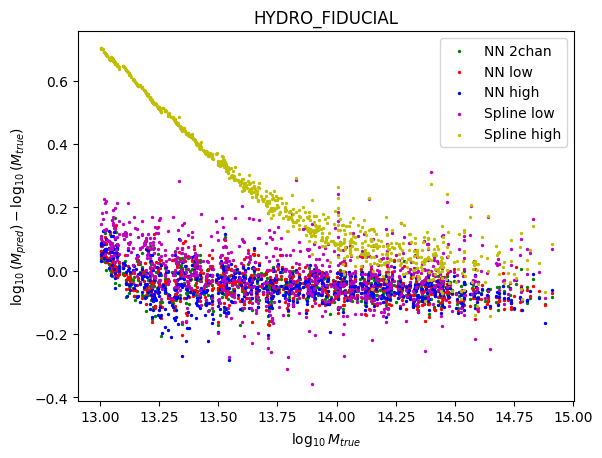

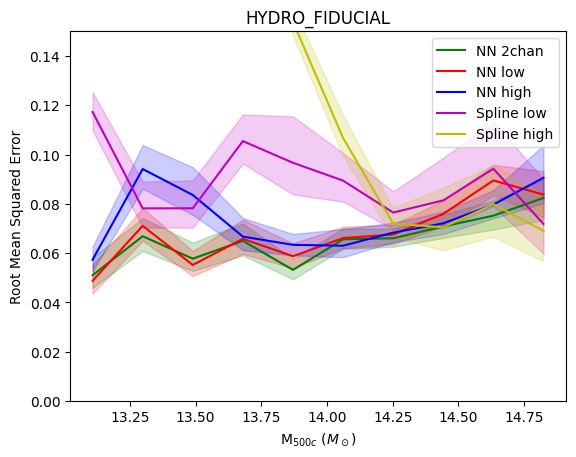

In [11]:
names = ["NN", "Spline low", "Spline high"]
colors = ["green", "m", "y"]
names = ["NN 2chan", "NN low", "NN high", "Spline low", "Spline high"]
colors = ["green", "red", "blue", "m", "y"]


for i in range(0, 5):
    plt.scatter(np.log10(data.masses), np.log10(predictions[:,i]) - np.log10(data.masses), label=names[i], color=colors[i], s=2)
plt.ylabel("$\log_{10}(M_{pred}) - \log_{10}(M_{true})$")
plt.xlabel("$\log_{10} M_{true}$")
plt.title(p["model"])
plt.legend()
# plt.savefig("/home/tol/Documents/Thesis/plots/error_"+p_to_filename(p)+"_scalingrelation", dpi=200)
plt.show()

def rmse(d):
    return np.sqrt(np.mean((d)**2))

from scipy.stats import bootstrap
for i in range(0, 5):
    nr_bins = 10
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    bin_edges = np.logspace(np.log10(np.min(data.masses)), np.log10(np.max(data.masses)), nr_bins+1)
    for b in range(nr_bins):
        indices = np.logical_and(data.masses > bin_edges[b], data.masses < bin_edges[b+1])
        error = np.log10(predictions[indices,i]) - np.log10(data.masses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, rmse(error))
        b = bootstrap((error,), rmse, confidence_level=0.84)
        perc16 = np.append(perc16, b.confidence_interval.low)
        perc84 = np.append(perc84, b.confidence_interval.high)
    plt.plot(x, y, label=names[i], color=colors[i])
    plt.fill_between(x, perc16, perc84, color=colors[i], alpha=0.2)
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("Root Mean Squared Error")
plt.title(p["model"])
plt.legend()
plt.ylim(0, 0.15)
# plt.savefig("/home/tol/Documents/Thesis/plots/RMSE_"+p_to_filename(p), dpi=200)
plt.show()

In [3]:
data.load_testset(p_to_filename(p))

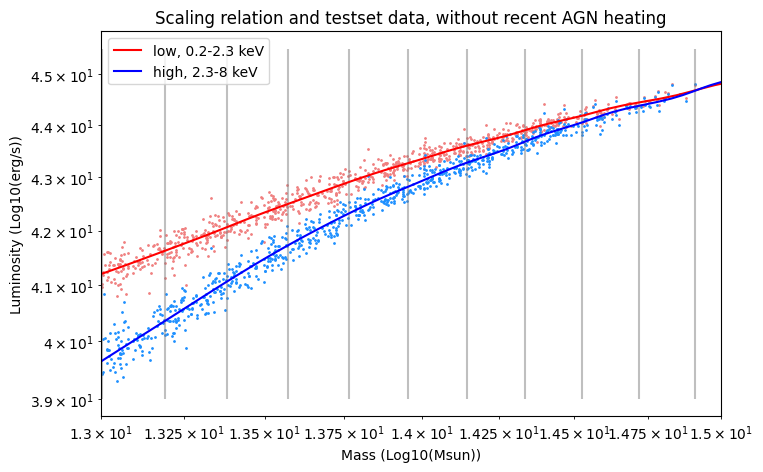

In [8]:
spl_low = np.load(f"{p['model_path']}/spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['model_path']}/spline_fit_high.npy", allow_pickle=True)[()]

plt.figure(figsize=(8, 5))
masses = np.log10(data.soap_file[f"{data.selection_type}/TotalMass"][()][data.indices])
lum_low = np.log10(data.soap_file[f"{data.selection_type}/XRayLuminosityWithoutRecentAGNHeating"][()][data.indices][:,0])
lum_high = np.log10(data.soap_file[f"{data.selection_type}/XRayLuminosityWithoutRecentAGNHeating"][()][data.indices][:,1])
plt.scatter(masses, lum_low, color="lightcoral", s=1, alpha=1)
plt.scatter(masses, lum_high, color="dodgerblue", s=1, alpha=1)

y = np.linspace(39.0, 45.5, 100)
x_low = spl_low(y)
x_high = spl_high(y)

nr_bins=10
bin_edges = np.log10(np.logspace(np.min(masses), np.max(masses), nr_bins+1))
plt.vlines(bin_edges, 39, 45.5, color="gray", alpha=0.5)

plt.plot(x_low, y, color="red", label="low, 0.2-2.3 keV")
plt.plot(x_high, y, color="blue", label="high, 2.3-8 keV")
plt.xlim(13, 15)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass (Log10(Msun))")
plt.ylabel("Luminosity (Log10(erg/s))")
plt.title("Scaling relation and testset data, without recent AGN heating")
plt.legend()
plt.savefig("ScalingRelation", dpi=300)
plt.show()

[]
11024165
[8.36277945e+43 5.72327719e+43 5.74069964e+43]
(2, 64, 64)
5.01255525522551e+43
1.5295475977692832e+43


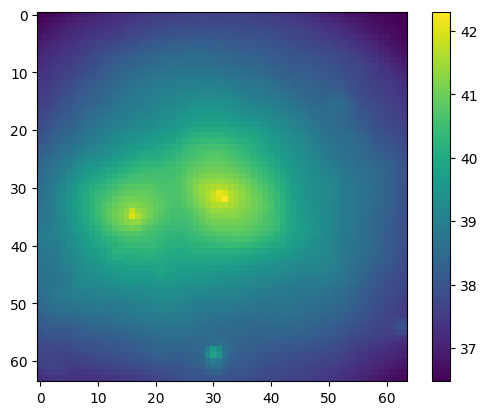

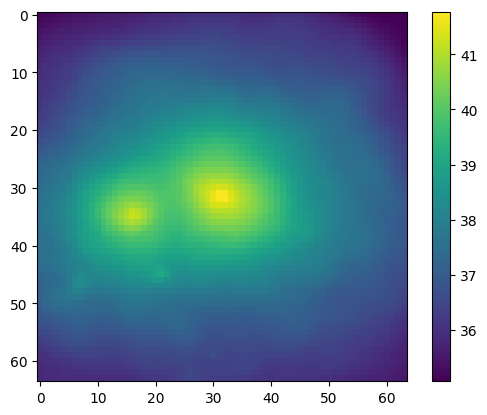

In [12]:
mask = np.logical_and(masses > 14.3, masses < 14.45)
# print(lum_low[mask] > 45)
print(np.argwhere(lum_low[mask] > 45))
index_in_mask = 0
soap_index = data.indices[mask][index_in_mask]
print(soap_index)
print(data.soap_file[f"{data.selection_type}/XRayLuminosityWithoutRecentAGNHeating"][soap_index])
print(data.images[mask][index_in_mask].shape)
print(np.sum(data.images[mask][index_in_mask][0, :, :]))
print(np.sum(data.images[mask][index_in_mask][1, :, :]))
plt.imshow(np.log10(data.images[mask][index_in_mask][0, :, :]))
plt.colorbar()
plt.show()
plt.imshow(np.log10(data.images[mask][index_in_mask][1, :, :]))
plt.colorbar()
plt.show()

[-0.24731446 -0.14384747 -0.11290742 -0.09025383 -0.08607387 -0.0734625
 -0.07245542 -0.06517983 -0.06362344 -0.03210067 -0.02991772 -0.02373696
 -0.01521681  0.08068372]
5134042
[44.36102482 44.27130419 44.2001508 ]


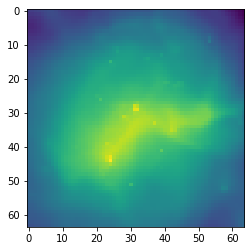

In [73]:
errors = (np.log10(predictions[:,1]) - np.log10(data.masses))[data.masses > 10**(14.75)] #errors
error = errors[np.argmin(errors)]
ids = np.argsort(errors)
print(errors[ids])
print(data.indices[ids[0]])
print(np.log10(data.soap_file["SO/500_crit/XRayLuminosityWithoutRecentAGNHeating"][data.indices[data.masses > 10**(14.75)][ids[0]]]))

plt.imshow(np.log10(data.images[data.masses > 10**(14.75)][ids[0], 0]))
plt.show()

[511.12029945 513.50939945 300.09884945]
[511.13891198 513.51318198 300.08858198]
0.39746094
0.054321348393760516


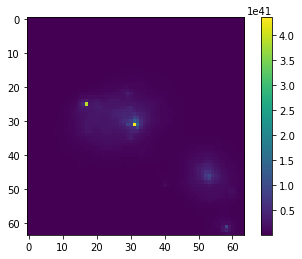

In [43]:
i = 501
halo = data.indices[i]
print(data.soap_file["SO/500_crit/CentreOfMass"][halo])
print(data.soap_file["VR/CentreOfPotential"][halo])
print(data.soap_file["SO/500_crit/SORadius"][halo])
print(np.linalg.norm(data.soap_file["SO/500_crit/CentreOfMass"][halo] - data.soap_file["VR/CentreOfPotential"][halo])/data.soap_file["SO/500_crit/SORadius"][halo])
plt.imshow((data.images[i, 0]))
plt.colorbar()

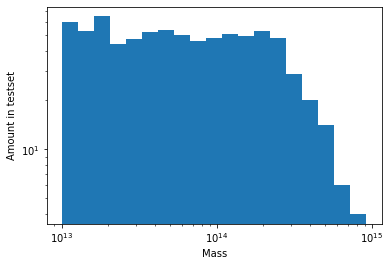

In [89]:
bins = np.logspace(np.min(np.log10(data.masses)), np.max(np.log10(data.masses)), 20)
plt.hist(data.masses, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass")
plt.ylabel("Amount in testset")
plt.show()

101072


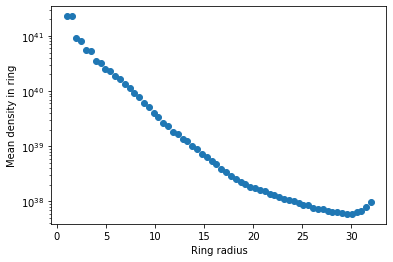

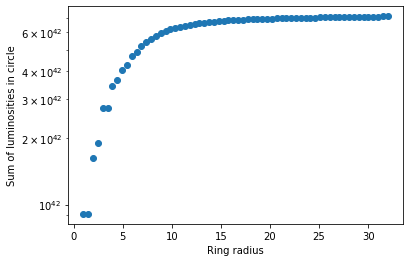

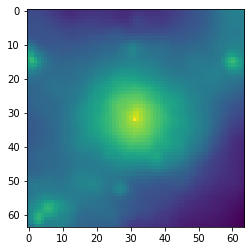

101073


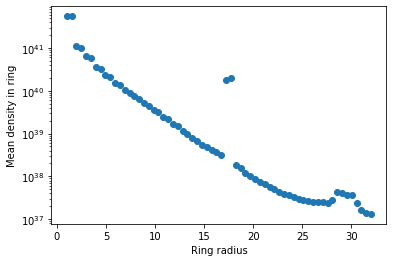

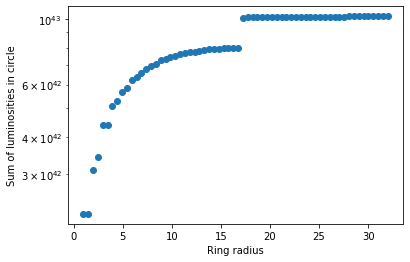

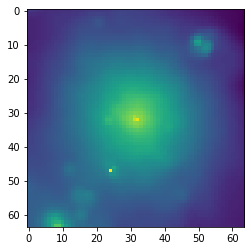

101221


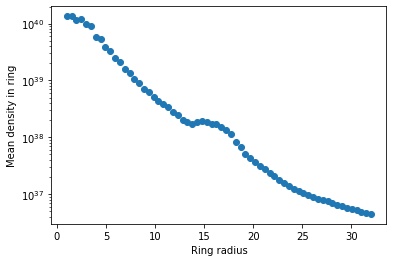

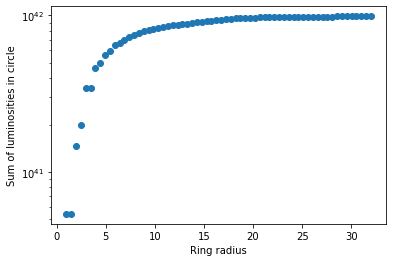

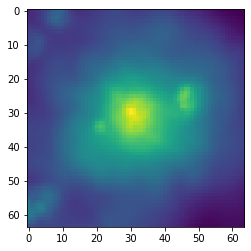

In [29]:
for i in range(23, 26):
    print(np.load(f"{filepath}_halo_indices.npy")[i])
    ringdensities = []
    circlesum = []
    radii = []
    for radius in np.linspace(1, resolution/2, resolution):
        X, Y = np.ogrid[:resolution, :resolution]
        dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
        mask_outer = dist_from_center<=radius
        mask_inner = dist_from_center<=(radius-1)
        ringdensities.append(np.mean(images[i,0][mask_outer != mask_inner]))
        circlesum.append(np.sum(images[i, 0][mask_outer]))
        radii.append(radius)
        # plt.imsindices_yhow(mask_outer != mask_inner)
        # plt.show()
    plt.scatter(radii, ringdensities)
    plt.xlabel("Ring radius")
    plt.ylabel("Mean density in ring")
    plt.yscale("log")
    plt.show()

    plt.scatter(radii, circlesum)
    plt.xlabel("Ring radius")
    plt.ylabel("Sum of luminosities in circle")
    plt.yscale("log")
    plt.show()

    plt.imshow(np.log10(images[i,0]))
    plt.show()

In [20]:
rhocrit = 10**-26 * unyt.kg / unyt.m**3
print((1*unyt.kpc).in_units(unyt.m))
print(rhocrit.in_units(unyt.Msun / unyt.kpc**3) * 500)
print(densities/(data.soap_file[f"{data.selection_type}/SORadius"][np.load(f"{filepath}_halo_indices.npy")][0]*unyt.Mpc).in_units(unyt.kpc))
# print(densities/)

3.085677580962325e+19 m
1.4689994722925896e+35 kg/kpc**3
[4.24400258e+39 4.24400258e+39 1.85087789e+39 1.68565107e+39
 1.10853738e+39 1.04687237e+39 7.68507952e+38 7.30234012e+38
 5.88015903e+38 5.38471272e+38 4.48587299e+38 4.03223660e+38
 3.32435383e+38 2.90753435e+38 2.45271490e+38 2.13558635e+38
 1.75507498e+38 1.54878351e+38 1.30765121e+38 1.16623888e+38
 1.00206669e+38 9.15380743e+37 7.74034912e+37 7.13176635e+37
 5.95924439e+37 5.42567354e+37 4.66281236e+37 4.28402370e+37
 3.75639133e+37 3.44556023e+37 3.07541432e+37 2.83026900e+37
 2.53015069e+37 2.36017490e+37 2.14626525e+37 1.97953419e+37
 1.83648714e+37 1.70398040e+37 1.56804556e+37 1.45769331e+37
 1.32251153e+37 1.22138017e+37 1.11425012e+37 1.02580571e+37
 9.29058411e+36 8.62632072e+36 8.04965677e+36 7.39131141e+36
 6.97388765e+36 6.49736946e+36 5.86454569e+36 5.48516043e+36
 4.93397350e+36 4.53046074e+36 4.17284699e+36 3.80484242e+36
 3.39599671e+36 3.07604479e+36 2.76475019e+36 2.51212955e+36
 2.31493351e+36 2.09566705e+

In [69]:
print((data.soap_file[p["selection_type"]].keys()))
print(data.soap_file.keys())

<KeysViewHDF5 ['AngularMomentumBaryons', 'AngularMomentumDarkMatter', 'AngularMomentumGas', 'AngularMomentumStars', 'BaryonInertiaTensor', 'BlackHolesDynamicalMass', 'BlackHolesLastEventScalefactor', 'BlackHolesSubgridMass', 'CentreOfMass', 'CentreOfMassVelocity', 'ComptonY', 'ComptonYWithoutRecentAGNHeating', 'DarkMatterInertiaTensor', 'DarkMatterMass', 'DiscToTotalGasMassFraction', 'DiscToTotalStellarMassFraction', 'DopplerB', 'GasCentreOfMass', 'GasCentreOfMassVelocity', 'GasComptonYTemperature', 'GasComptonYTemperatureCoreExcision', 'GasComptonYTemperatureWithoutRecentAGNHeating', 'GasComptonYTemperatureWithoutRecentAGNHeatingCoreExcision', 'GasInertiaTensor', 'GasMass', 'GasMassFractionInIron', 'GasMassFractionInMetals', 'GasMassFractionInOxygen', 'GasTemperature', 'GasTemperatureCoreExcision', 'GasTemperatureWithoutCoolGas', 'GasTemperatureWithoutCoolGasAndRecentAGNHeating', 'GasTemperatureWithoutCoolGasAndRecentAGNHeatingCoreExcision', 'GasTemperatureWithoutCoolGasCoreExcision',

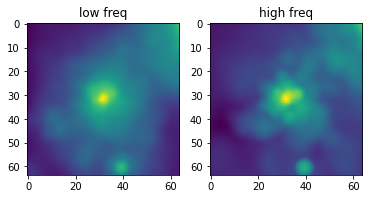

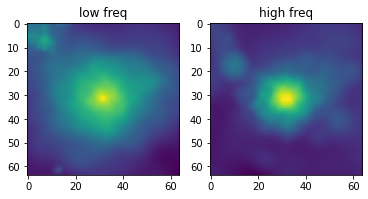

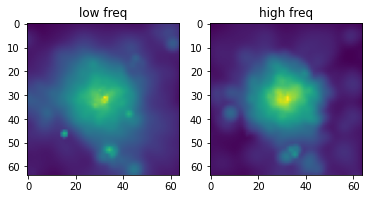

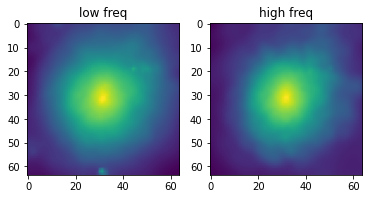

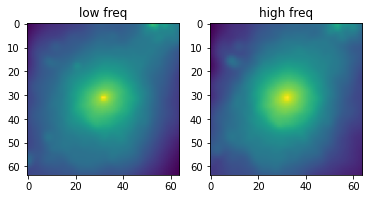

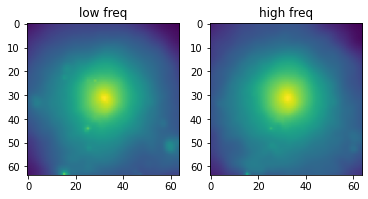

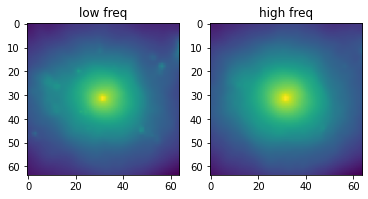

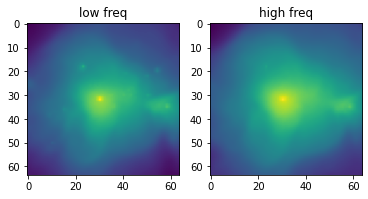

In [49]:
mass_sort = np.argsort(masses)
for i in mass_sort[1::50]:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.log10(images[i,0,:,:]))
    axs[0].set_title("low freq")
    axs[1].imshow(np.log10(images[i,1,:,:]))
    axs[1].set_title("high freq")
    # plt.title(f"Mass: {np.log10(masses[i]):.01f}")
    plt.show()

# Param search networks exploration

['obs_model_2chanbyhand25.json', 'obs_model_2chanbyhand6.json', 'obs_model_2chanbyhand23.json', 'obs_model_2chanbyhand3.json', 'obs_model_2chanbyhand19.json', 'obs_model_2chanbyhand12.json', 'obs_model_2chanbyhand1.json', 'obs_model_2chanbyhand13.json', 'obs_model_2chanbyhand14.json', 'obs_model_2chanbyhand4.json', 'obs_model_2chanbyhand32.json', 'obs_model_2chanbyhand7.json', 'obs_model_2chanbyhand29.json', 'obs_model_2chanbyhand31.json', 'obs_model_2chanbyhand27.json', 'obs_model_2chanbyhand11.json', 'obs_model_2chanbyhand26.json', 'obs_model_2chanbyhand28.json', 'obs_model_2chanbyhand18.json', 'obs_model_2chanbyhand20.json', 'obs_model_2chanbyhand2.json', 'obs_model_2chanbyhand8.json', 'obs_model_2chanbyhand17.json', 'obs_model_2chanbyhand21.json', 'obs_model_2chanbyhand10.json', 'obs_model_2chanbyhand24.json', 'obs_model_2chanbyhand15.json', 'obs_model_2chanbyhand30.json', 'obs_model_2chanbyhand5.json']
obs_model_2chanbyhand25.json 0.011247528716921806
obs_model_2chanbyhand6.json 0

Text(0.5, 1.0, 'Validation loss curves for all networks')

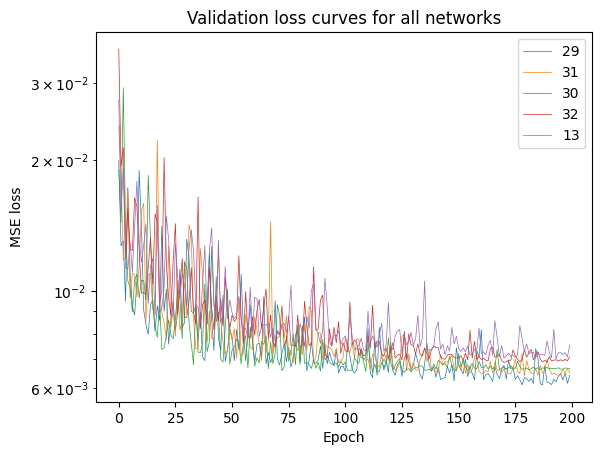

In [90]:
from os import listdir
import json

flist = listdir(p["model_path"]+"paramSearchByHand/")

files = []
for file in flist:
    if ".json" in file:
        files.append(file)
    
print(files)
vallosses = []
best = 1000.0
fig, ax = plt.subplots()
for modelname in files:
    filepath = open(p['model_path']+"paramSearchByHand/" + modelname, 'r')
    d = json.load(filepath)
    vallosses.append(np.min(d["vallosses"]))
    if d["vallosses"][-1] < best:
        best = d["vallosses"][-1]
        print(modelname, best)
    # modelnr = int(modelname[21:-5])
    # ax.plot(range(d["nr_epochs"]), d["vallosses"], label=modelnr, lw=0.5)

for i in np.argsort(vallosses)[:5]:
    print(files[i])

    filepath = open(p['model_path']+"paramSearchByHand/" + files[i], 'r')
    d = json.load(filepath)

#     # c = "blue" if d["use_batch_norm"] else "red"
#     # l = "Batch Norm" if d["use_batch_norm"] else "No Batch Norm"

    modelnr = int(files[i][21:-5])
    ax.plot(range(d["nr_epochs"]), d["vallosses"], label=modelnr, lw=0.5)
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
# ax.set_ylim(7e-3, 1e-2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Validation loss curves for all networks")
# plt.savefig(p["data_path"] + "plots/loss_use_batch_norm", dpi=300)

# prediction exploration

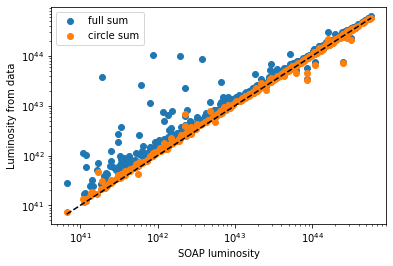

In [39]:
lums = data.soap_file[f"{data.selection_type}/XRayLuminosityWithoutRecentAGNHeating"][indices][:int(len(indices)*data.test_size), 0]

pixel_size = 2 * 2000 / 64  #kpc
lums_circle = []
for i, haloindex in enumerate(indices[:int(len(indices)*data.test_size)]):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    X, Y = np.ogrid[:resolution, :resolution]
    dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
    mask_outer = dist_from_center<=radius
    lums_circle.append(np.sum(images[i, 0][mask_outer]))

plt.scatter(lums, np.sum(images[:,0,:,:], axis=(1, 2)), label="full sum")
plt.scatter(lums, lums_circle, label="circle sum")
diag = np.linspace(np.min(lums), np.max(lums), 20)
plt.plot(diag, diag, color="black", ls="dashed")
plt.xlabel("SOAP luminosity")
plt.ylabel("Luminosity from data")
# plt.title("Sum over pixels within SORadius")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()



# simulation exploration


In [4]:
soap_path = "halo_properties_0077.hdf5"
data = Data(p)

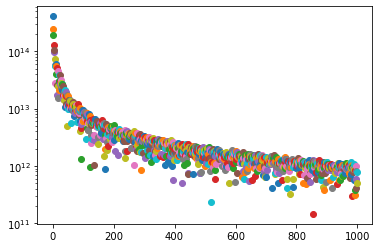

In [8]:
for i, mass in enumerate(data.soap_file[f"{p['selection_type']}/TotalMass"][:10000:10]):
    plt.scatter(i, mass)
plt.yscale("log")
plt.show()

KeyError: 'Unable to synchronously open object (component not found)'

[1.00126345e+11 1.62548522e+11 2.63886813e+11 4.28402849e+11
 6.95483792e+11 1.12907210e+12 1.83297414e+12 2.97571272e+12
 4.83087349e+12 7.84260473e+12 1.27319519e+13 2.06694848e+13
 3.35555464e+13 5.44752181e+13 8.84369263e+13 1.43571521e+14
 2.33078903e+14 3.78388238e+14 6.14288367e+14 9.97256679e+14]


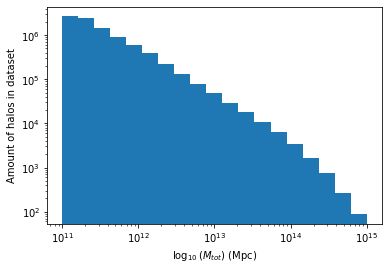

In [23]:
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]
mass = mass[np.logical_and(np.logical_and(mass > 1e11, mass !=0), mass < 1e15)]
bins = np.logspace(np.log10(np.min(mass)), np.log10(np.max(mass)), 20)
print(bins)
ret = plt.hist(mass, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Amount of halos in dataset")
plt.xlabel("$\log_{10}(M_{tot})$ (Mpc)")
plt.show()

In [24]:
print(ret)

(array([2.658175e+06, 2.436279e+06, 1.443613e+06, 8.889650e+05,
       5.937730e+05, 3.860400e+05, 2.274540e+05, 1.318370e+05,
       7.770900e+04, 4.786600e+04, 2.939100e+04, 1.817200e+04,
       1.072000e+04, 6.328000e+03, 3.430000e+03, 1.670000e+03,
       7.550000e+02, 2.690000e+02, 8.800000e+01]), array([1.00126345e+11, 1.62548522e+11, 2.63886813e+11, 4.28402849e+11,
       6.95483792e+11, 1.12907210e+12, 1.83297414e+12, 2.97571272e+12,
       4.83087349e+12, 7.84260473e+12, 1.27319519e+13, 2.06694848e+13,
       3.35555464e+13, 5.44752181e+13, 8.84369263e+13, 1.43571521e+14,
       2.33078903e+14, 3.78388238e+14, 6.14288367e+14, 9.97256679e+14]), <BarContainer object of 19 artists>)
